# **Proiect IC - Crîșciu Emanuel-Ilie**
## SGConv (Simple Graph Convolution)

- Acest notebook conține implementarea rețelei neuronale propuse de către **Felix Wu, Tianyi Zhang, Amauri Holanda de Souza Jr., Christopher Fifty, Tao Yu și Kilian Q. Weinberger** în paper-ul **"Simplifying Graph Convolutional Networks"**.
- Voi aborda atât codul aflat în link-ul dat în paper, cât și o variantă mai "manuală" ce urmărește pașii teoretici expuși în paper.

Se realizează toate importurile necesare:

In [1]:
import os
import os.path as osp

import torch
import torch.nn.functional as F

from torch_geometric.datasets import Planetoid
from torch_geometric.nn import SGConv

import networkx as nx
import matplotlib.pyplot as plt

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

## Setul de date "Cora"

Voi testa rețeaua neuronală SGC pe setul de date "Cora", utilizând codul scris de autori.

Mai întâi se obține setul de date "Cora" și se afișează câteva date sumare despre el pentru a verifica corectitudinea:

In [2]:
dataset = 'Cora'
path = osp.join(os.getcwd(), 'data', dataset)
dataset = Planetoid(path, dataset)
data = dataset[0]

print(f"{dataset.name}.x shape: {data.x.shape}")
print(f"{dataset.name}.y shape: {data.y.shape}")
print(f"{dataset.name}.edge_index shape: {data.edge_index.shape}")
print(f"{dataset.name}.num_nodes: {data.num_nodes}")

Cora.x shape: torch.Size([2708, 1433])
Cora.y shape: torch.Size([2708])
Cora.edge_index shape: torch.Size([2, 10556])
Cora.num_nodes: 2708


Creez o funcție pentru afișarea unui set de date sub formă de graf:

In [3]:
def plot_dataset(data):
    # Se creează un graf cu ajutorul NetworkX
    G = nx.Graph()
    edge_index = data.edge_index

    # Se adaugă nodurile grafului
    G.add_nodes_from(range(len(data.x)))
    
    # Se adaugă muchiile grafului, conform edge index-ului
    G.add_edges_from(edge_index.t().tolist())
    
    # Define the node colors based on the labels  VEDEM AICI CE ȘI CUM
    node_labels = data.y.tolist()
    
    # Se verifică dacă avem atâtea etichete câte noduri există în graf
    assert len(node_labels) == data.num_nodes, "Node label count must match the number of nodes"
    
    # Se definește poziția nodurilor utilizând "spring layout"
    pos = nx.spring_layout(G, k=0.125, seed=42)  # Adjust 'k' for spacing between nodes
    
    # Se desenează graful
    plt.figure(figsize=(10, 10))
    #node_color=node_labels
    nx.draw_networkx(G, pos, node_color=node_labels, with_labels=False, node_size=25) #node_color=node_labels, cmap='viridis' 'purple'
    plt.title(f'{dataset.name} Dataset Graph')
    plt.show()

Se afișează setul de date:

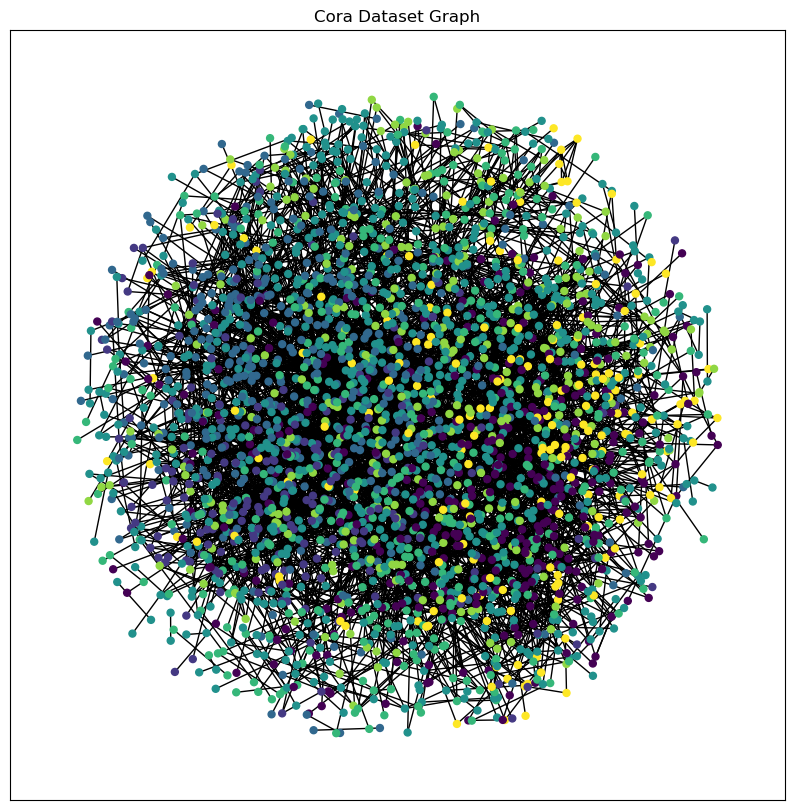

In [4]:
plot_dataset(data)

Codul de mai jos este preluat din repository-ul de GitHub al celor ce au scris paper-ul. Aici se definește rețeaua neuronală:

In [5]:
class Net(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # Rețeaua neuronală conține un singur strat SGConv ce este implementat conform teoriei expuse în paper
        self.conv1 = SGConv(
            in_channels=dataset.num_features,
            out_channels=dataset.num_classes,
            K=2,
            cached=True,
        )

    def forward(self):
        # Datele de intrare trec prin acest strat SGConv și apoi se aplică un clasificator softmax pentru a obține șansa ca un nod să aparțină
        # unei clase de la ieșire.
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        return F.log_softmax(x, dim=1)

Se selectează device-ul pe care va rula codul:

In [6]:
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

In [7]:
device

device(type='cuda')

Se instanțiază rețeaua neuronală și se alege optimizatorul:

In [8]:
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.2, weight_decay=0.005)

Apoi sunt implementate funcțiile de antrenare și testare:

In [9]:
def train():
    model.train()
    optimizer.zero_grad()
    loss = F.nll_loss(model()[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

In [10]:
@torch.no_grad()
def test():
    model.eval()
    output = model()
    accs = []
    for _, mask in data('train_mask', 'val_mask', 'test_mask'):
        pred = output[mask].argmax(dim=1)
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

Aici este declarată funcția care va antrena rețeaua neuronală implementată de autori și care va stoca valorile acurateței din diferite puncte de vedere, precum și pe cele ale pierderii:

In [11]:
train_accuracies = []
val_accuracies = []
test_accuracies = []
loss_values = []

def networkTraining(num_epochs):
    best_val_acc = test_acc = 0
    
    for epoch in range(1, num_epochs + 1):
        loss = train()
        train_acc, val_acc, tmp_test_acc = test()
        loss_values.append(loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        test_accuracies.append(test_acc)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            test_acc = tmp_test_acc
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {best_val_acc:.4f}, Test: {test_acc:.4f}')
    print(f'Final Test Accuracy: {test_acc:.4f}')

Modelul este antrenat pentru 100 de epoci, așa cum este precizat în paper:

In [12]:
num_epochs = 100
networkTraining(num_epochs)

Epoch: 001, Loss: 1.9476, Train: 0.9500, Val: 0.7020, Test: 0.7530
Epoch: 002, Loss: 0.4743, Train: 0.9643, Val: 0.7120, Test: 0.7090
Epoch: 003, Loss: 0.2599, Train: 0.9857, Val: 0.7900, Test: 0.8000
Epoch: 004, Loss: 0.1879, Train: 0.9786, Val: 0.7900, Test: 0.8000
Epoch: 005, Loss: 0.1985, Train: 1.0000, Val: 0.7900, Test: 0.8000
Epoch: 006, Loss: 0.2269, Train: 0.9929, Val: 0.7900, Test: 0.8000
Epoch: 007, Loss: 0.2765, Train: 1.0000, Val: 0.7900, Test: 0.8000
Epoch: 008, Loss: 0.3228, Train: 1.0000, Val: 0.7900, Test: 0.8000
Epoch: 009, Loss: 0.3427, Train: 0.9929, Val: 0.7900, Test: 0.8000
Epoch: 010, Loss: 0.3520, Train: 0.9929, Val: 0.7900, Test: 0.8000
Epoch: 011, Loss: 0.3328, Train: 0.9929, Val: 0.7900, Test: 0.8000
Epoch: 012, Loss: 0.3130, Train: 0.9929, Val: 0.7900, Test: 0.8000
Epoch: 013, Loss: 0.2982, Train: 0.9929, Val: 0.7900, Test: 0.8000
Epoch: 014, Loss: 0.2846, Train: 0.9929, Val: 0.7900, Test: 0.8000
Epoch: 015, Loss: 0.2833, Train: 1.0000, Val: 0.7900, Test: 0.

Am implementat o funcție ce va afișa graficele metricelor obținute în urma antrenării:

In [13]:
def plotAccuraciesAndLoss():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,6))
    
    axes[0].plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
    axes[0].plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    axes[0].plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_title(f'Evolution of Training, Validation and Test Accuracies on {dataset.name} Dataset')
    axes[0].legend()
    
    axes[1].plot(range(1, num_epochs + 1), loss_values, label='Loss')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Loss')
    axes[1].set_title(f'Evolution of Loss Function on {dataset.name} Dataset')
    axes[1].legend()
    
    plt.show()

Se afișează graficele menționate:

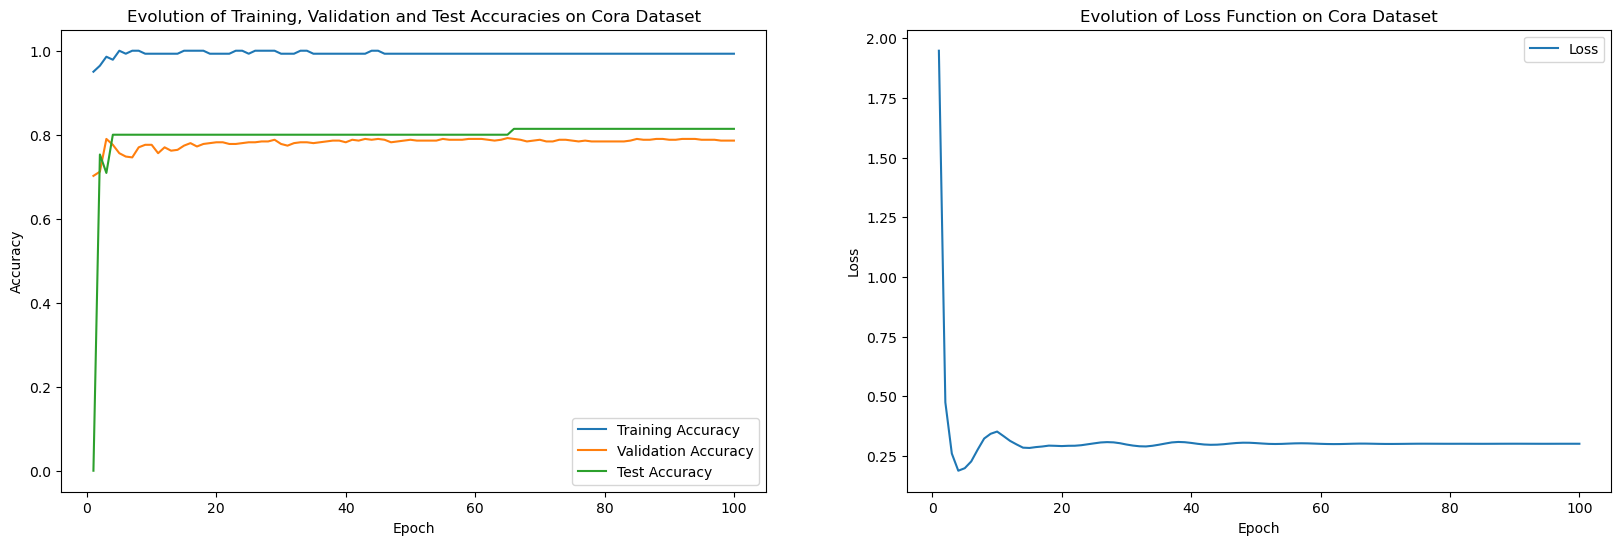

In [14]:
plotAccuraciesAndLoss()

Voi implementa rețeaua neuronală SGC respectând indicațiile teoretice din paper, pentru a vedea ce rezultate se obțin în comparație cu rețeaua neuronală gata scrisă de autori:

In [15]:
import torch.nn as nn

# Rețeaua neuronală SGC e alcătuită dintr-un singur layer liniar, restul prelucrărilor având loc în funcția de forward.
# Un SGC se comportă ca o rețea GCN (Graph Convolutional Network) doar că este mult mai simplă și mai rapidă și se rezumă la
# a face o pre-procesare a datelor și apoi aplicarea unei transformări liniare prin intermediul unui layer liniar.

class SGC(nn.Module):
    def __init__(self, in_features, out_features, K=3):
        super(SGC, self).__init__()
        
        # Se definește un layer liniar
        self.linear = nn.Linear(in_features, out_features)
        
        # K reprezintă numărul de pași de propagare
        self.K = K

    def forward(self, data):
        
        # Se extrag feature map-ul și edge index-ul din dataset.
        # La început, reprezentarea curentă a nodurilor grafului este considerată chiar feature map-ul.
        # Feature map-ul este o matrice ce conține feature vectorii fiecărui nod, transpuși și așezați unul peste celălalt.
        # Edge index-ul este o matrice cu 2 rânduri și are atâtea coloane câte muchii există în graf.
        x, edge_index = data.x, data.edge_index

        # Se ține cont de faptul că nodurile au legături cu ele însele (conform paper-ului), așa că vom forța acest lucru.
        # Se construieșe un tensor de 2 x num_nodes ce va conține de fapt doi vectori cu numerele nodurilor în ordine (Ex: [1,2,3,4,5]),
        # stacați unul peste celălalt.
        num_nodes = data.num_nodes
        self_loops = torch.cat([torch.arange(num_nodes, device=edge_index.device).unsqueeze(0)] * 2, dim=0)

        # La edge index-ul existent se lipește (concatenează) tensorul self_loops.
        edge_index_with_self_loops = torch.cat([edge_index, self_loops], dim=1)
        
        # Se fac cei K pași de propagare a feature-urilor.
        for _ in range(self.K):
            
            # row și col reprezintă primul, respectiv al doilea rând din matricea edge index.
            row, col = edge_index_with_self_loops
            
            # Se calculează Degree matrix-ul grafului nostru, incrementând tensorul, care inițial e unidimensional, în pozițiile indicate de row.
            deg = torch.zeros(data.num_nodes, device=x.device)
            deg.scatter_add_(0, row, torch.ones_like(row, dtype=deg.dtype))
            # În punctul acesta avem Degree matrix-ul calculat, tot sub formă de vector, ce conține gradul fiecărui nod din graf.
            
            # Urmează să calculăm inversul rădăcinii pătrate al acestui tensor, conform formulelor din paper.
            deg_inv_sqrt = deg.pow(-0.5)
            
            # În pozițiile unde gradul unui nod ar fi 0 am obține infinități, așa că le înlocuim cu 0.
            deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
            
            # La final, tensorul obținut este transformat într-o matrice diagonală de grade ale nodurilor.
            D_inv_sqrt = torch.diag(deg_inv_sqrt)

            # Se construiește matricea de adiacență a grafului, punându-se 1 în pozițiile date de edge index, adică între nodurile cu muchii.
            adj_matrix = torch.sparse_coo_tensor(edge_index_with_self_loops, torch.ones(edge_index_with_self_loops.size(1), device=x.device), size=(data.num_nodes, data.num_nodes))
            
            # Se obține, așa cum se specifică în paper, o matrice ce are ca rezultat: D^(-1/2) x A x D^(-1/2), ce reprezintă de fapt
            # matricea de adiacență normalizată.
            adj_matrix = torch.sparse.mm(D_inv_sqrt, adj_matrix)
            adj_matrix = torch.sparse.mm(adj_matrix, D_inv_sqrt)

            # Se înmulțește matricea de adiacență normalizată cu feature map-ul grafului (sau reprezentarea curentă a nodurilor) pentru a se 
            # obține noua reprezentare a nodurilor. Toți acești pași reprezintă pre-procesarea datelor și se fac în manieră iterativă (de K ori).
            x = torch.sparse.mm(adj_matrix, x)

        # Reprezentarea grafului este introdusă într-un layer liniar pentru a se aplica o transformare liniară asupra sa.
        # Aici are loc o înmulțire cu un vector de ponderi și apoi o adunare cu un vector de bias-uri.
        x = self.linear(x)

        # Ieșirea rețelei neuronale SGC va fi un layer softmax ce va indica probabilitatea ca un nod să facă parte din diversele clase.
        return torch.nn.functional.log_softmax(x, dim=1)


Se instanțiază modelul SGC:

In [16]:
in_features = data.num_features  # Numărul de atribute al fiecărui nod
out_features = dataset.num_classes  # Numărul de clase de noduri
model = SGC(in_features, out_features, K=3)

In [17]:
model, data = model.to(device), data.to(device)

Se alege optimizatorul:

In [18]:
#from torch.optim import Adam
#optimizer = Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
from torch.optim import SGD
optimizer = SGD(model.parameters(), lr=0.2, momentum=0.9)

Se definesc funcțiile de antrenare și testare pentru modelul SGC:

In [19]:
def trainSGC():
    model.train()
    optimizer.zero_grad()
    loss = F.nll_loss(model(data)[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

In [20]:
@torch.no_grad()
def testSGC():
    model.eval()
    output = model(data)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        pred = output[mask].argmax(dim=1)
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

Se implementează funcția care va antrena modelul de tip SGC și care va stoca valorile acuratețelor și a pierderii:

In [21]:
# Training loop
train_accuracies = []
val_accuracies = []
test_accuracies = []
loss_values = []

def networkTrainingSGC(num_epochs):
    best_val_acc = test_acc = 0
    
    for epoch in range(1, num_epochs + 1):
        loss = trainSGC()
        train_acc, val_acc, tmp_test_acc = testSGC()
        loss_values.append(loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)
        test_accuracies.append(test_acc)
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            test_acc = tmp_test_acc
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {best_val_acc:.4f}, Test: {test_acc:.4f}')
    print(f'Final Test Accuracy: {test_acc:.4f}')

Se antrenează pentru 100 de epoci rețeaua SGC pe setul de date "Cora":

In [22]:
num_epochs = 100
networkTrainingSGC(num_epochs)

Epoch: 001, Loss: 1.9538, Train: 0.1714, Val: 0.1420, Test: 0.1630
Epoch: 002, Loss: 1.9390, Train: 0.3286, Val: 0.2440, Test: 0.2730
Epoch: 003, Loss: 1.9114, Train: 0.6643, Val: 0.4240, Test: 0.4590
Epoch: 004, Loss: 1.8725, Train: 0.7929, Val: 0.5420, Test: 0.5830
Epoch: 005, Loss: 1.8243, Train: 0.8429, Val: 0.6300, Test: 0.6390
Epoch: 006, Loss: 1.7685, Train: 0.8714, Val: 0.6740, Test: 0.6770
Epoch: 007, Loss: 1.7067, Train: 0.8857, Val: 0.6980, Test: 0.7070
Epoch: 008, Loss: 1.6405, Train: 0.8929, Val: 0.7220, Test: 0.7280
Epoch: 009, Loss: 1.5715, Train: 0.8929, Val: 0.7300, Test: 0.7390
Epoch: 010, Loss: 1.5008, Train: 0.9000, Val: 0.7380, Test: 0.7510
Epoch: 011, Loss: 1.4297, Train: 0.9000, Val: 0.7380, Test: 0.7510
Epoch: 012, Loss: 1.3593, Train: 0.8929, Val: 0.7400, Test: 0.7620
Epoch: 013, Loss: 1.2904, Train: 0.8929, Val: 0.7500, Test: 0.7710
Epoch: 014, Loss: 1.2238, Train: 0.9000, Val: 0.7500, Test: 0.7710
Epoch: 015, Loss: 1.1601, Train: 0.9071, Val: 0.7540, Test: 0.

Graficele obținute pentru setul de date "Cora" cu rețeaua SGC:

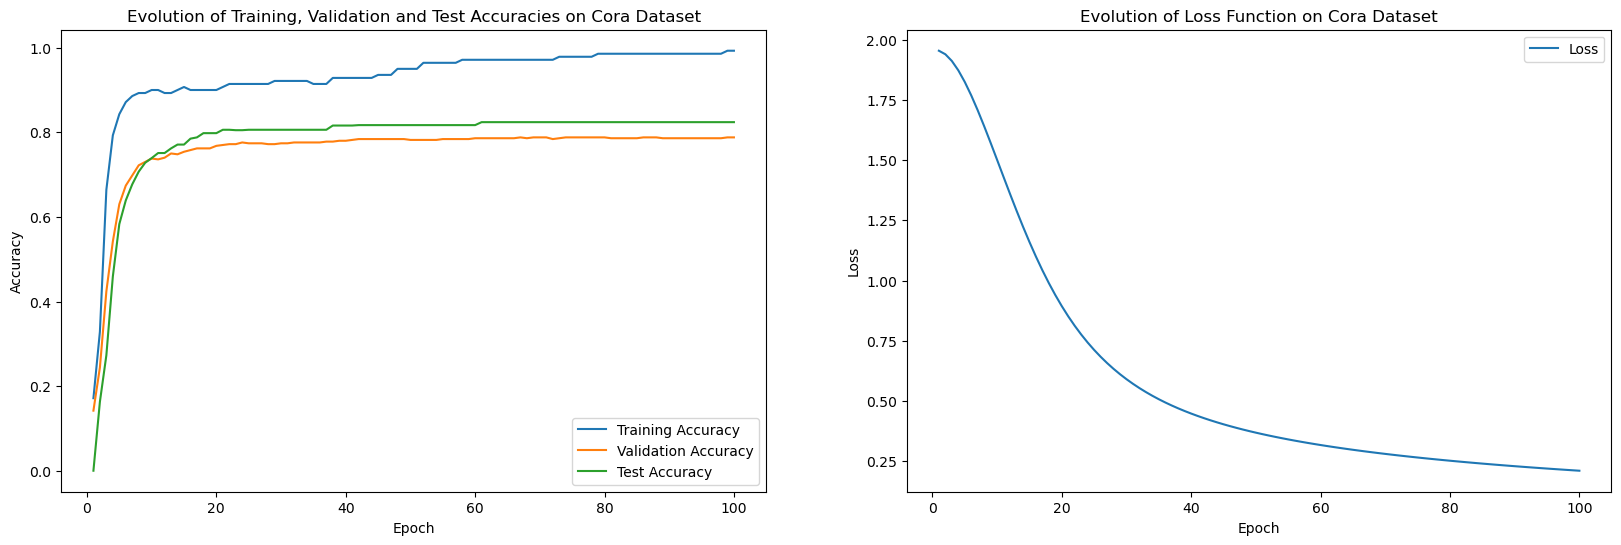

In [23]:
plotAccuraciesAndLoss()

## Setul de date "CiteSeer"

Se obține setul de date "CiteSeer" și se afișează câteva date sumare despre el pentru a verifica corectitudinea:

In [24]:
dataset = 'CiteSeer'
path = osp.join(os.getcwd(), 'data', dataset)
dataset = Planetoid(path, dataset)
data = dataset[0]

print(f"{dataset.name}.x shape: {data.x.shape}")
print(f"{dataset.name}.y shape: {data.y.shape}")
print(f"{dataset.name}.edge_index shape: {data.edge_index.shape}")
print(f"{dataset.name}.num_nodes: {data.num_nodes}")

CiteSeer.x shape: torch.Size([3327, 3703])
CiteSeer.y shape: torch.Size([3327])
CiteSeer.edge_index shape: torch.Size([2, 9104])
CiteSeer.num_nodes: 3327


Se afișează setul de date:

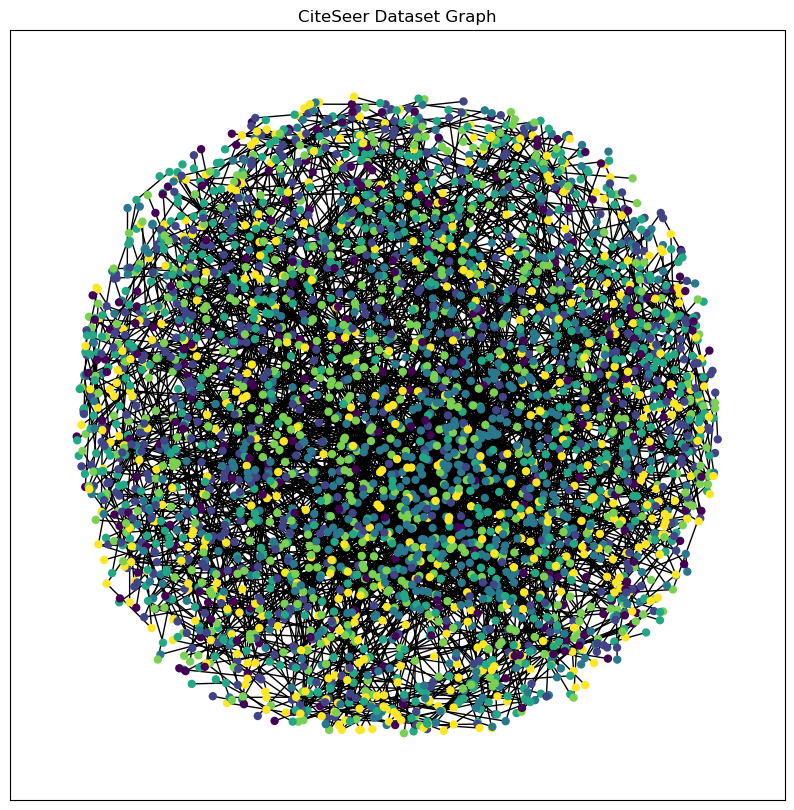

In [25]:
plot_dataset(data)

Se instanțiază rețeaua neuronală implementată de autori și se alege optimizatorul:

In [26]:
model, data = Net().to(device), data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.2, weight_decay=0.005)

Se antrenează modelul pentru 100 de epoci și se recalculează acuratețea și pierderea:

In [27]:
train_accuracies = []
val_accuracies = []
test_accuracies = []
loss_values = []

num_epochs = 100
networkTraining(num_epochs)

Epoch: 001, Loss: 1.7948, Train: 0.9583, Val: 0.6340, Test: 0.6170
Epoch: 002, Loss: 0.1451, Train: 0.9667, Val: 0.6360, Test: 0.6570
Epoch: 003, Loss: 0.1030, Train: 0.9917, Val: 0.6360, Test: 0.6570
Epoch: 004, Loss: 0.0786, Train: 0.9750, Val: 0.6360, Test: 0.6570
Epoch: 005, Loss: 0.1145, Train: 0.9833, Val: 0.6920, Test: 0.6770
Epoch: 006, Loss: 0.1605, Train: 0.9917, Val: 0.6920, Test: 0.6770
Epoch: 007, Loss: 0.2290, Train: 0.9917, Val: 0.6920, Test: 0.6770
Epoch: 008, Loss: 0.2698, Train: 0.9833, Val: 0.6920, Test: 0.6770
Epoch: 009, Loss: 0.2897, Train: 1.0000, Val: 0.6920, Test: 0.6770
Epoch: 010, Loss: 0.2552, Train: 1.0000, Val: 0.6920, Test: 0.6770
Epoch: 011, Loss: 0.1994, Train: 0.9833, Val: 0.7000, Test: 0.6810
Epoch: 012, Loss: 0.1698, Train: 0.9917, Val: 0.7160, Test: 0.6960
Epoch: 013, Loss: 0.1610, Train: 0.9917, Val: 0.7160, Test: 0.6960
Epoch: 014, Loss: 0.1686, Train: 1.0000, Val: 0.7160, Test: 0.6960
Epoch: 015, Loss: 0.1889, Train: 1.0000, Val: 0.7160, Test: 0.

Graficele ce arată acuratețea și pierderea obținute de către rețeaua neuronală implementată de autori:

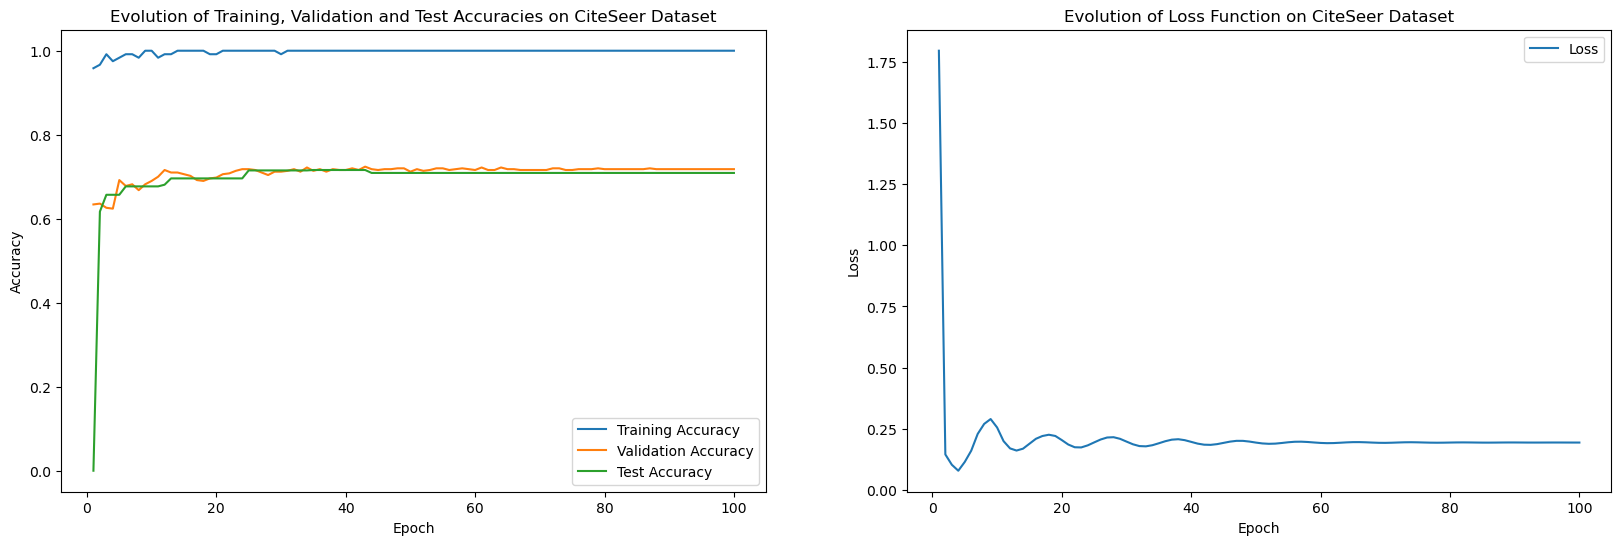

In [28]:
plotAccuraciesAndLoss()

Tot pentru setul de date "CiteSeer", instanțiem o rețea neuronală SGC și se alege optimizatorul SGD conform paper-ului:

In [29]:
in_features = data.num_features
out_features = dataset.num_classes
model = SGC(in_features, out_features, K=3)

In [30]:
model, data = model.to(device), data.to(device)

In [31]:
optimizer = SGD(model.parameters(), lr=0.2, momentum=0.9)

Se antrenează modelul pentru 100 de epoci și se recalculează acuratețea și pierderea:

In [32]:
# Training loop
train_accuracies = []
val_accuracies = []
test_accuracies = []
loss_values = []

num_epochs = 100
networkTrainingSGC(num_epochs)

Epoch: 001, Loss: 1.7950, Train: 0.3917, Val: 0.2880, Test: 0.3210
Epoch: 002, Loss: 1.7707, Train: 0.7000, Val: 0.5440, Test: 0.5440
Epoch: 003, Loss: 1.7253, Train: 0.7833, Val: 0.6200, Test: 0.6240
Epoch: 004, Loss: 1.6625, Train: 0.8083, Val: 0.6500, Test: 0.6580
Epoch: 005, Loss: 1.5863, Train: 0.8250, Val: 0.6580, Test: 0.6680
Epoch: 006, Loss: 1.5005, Train: 0.8250, Val: 0.6720, Test: 0.6740
Epoch: 007, Loss: 1.4091, Train: 0.8333, Val: 0.6760, Test: 0.6880
Epoch: 008, Loss: 1.3156, Train: 0.8417, Val: 0.6860, Test: 0.6890
Epoch: 009, Loss: 1.2229, Train: 0.8500, Val: 0.6940, Test: 0.7020
Epoch: 010, Loss: 1.1333, Train: 0.8500, Val: 0.7040, Test: 0.7070
Epoch: 011, Loss: 1.0484, Train: 0.8667, Val: 0.7080, Test: 0.7150
Epoch: 012, Loss: 0.9692, Train: 0.8750, Val: 0.7260, Test: 0.7140
Epoch: 013, Loss: 0.8964, Train: 0.8833, Val: 0.7300, Test: 0.7130
Epoch: 014, Loss: 0.8301, Train: 0.8833, Val: 0.7320, Test: 0.7150
Epoch: 015, Loss: 0.7703, Train: 0.9083, Val: 0.7360, Test: 0.

Graficele obținute în urma aplicării rețelei SGC:

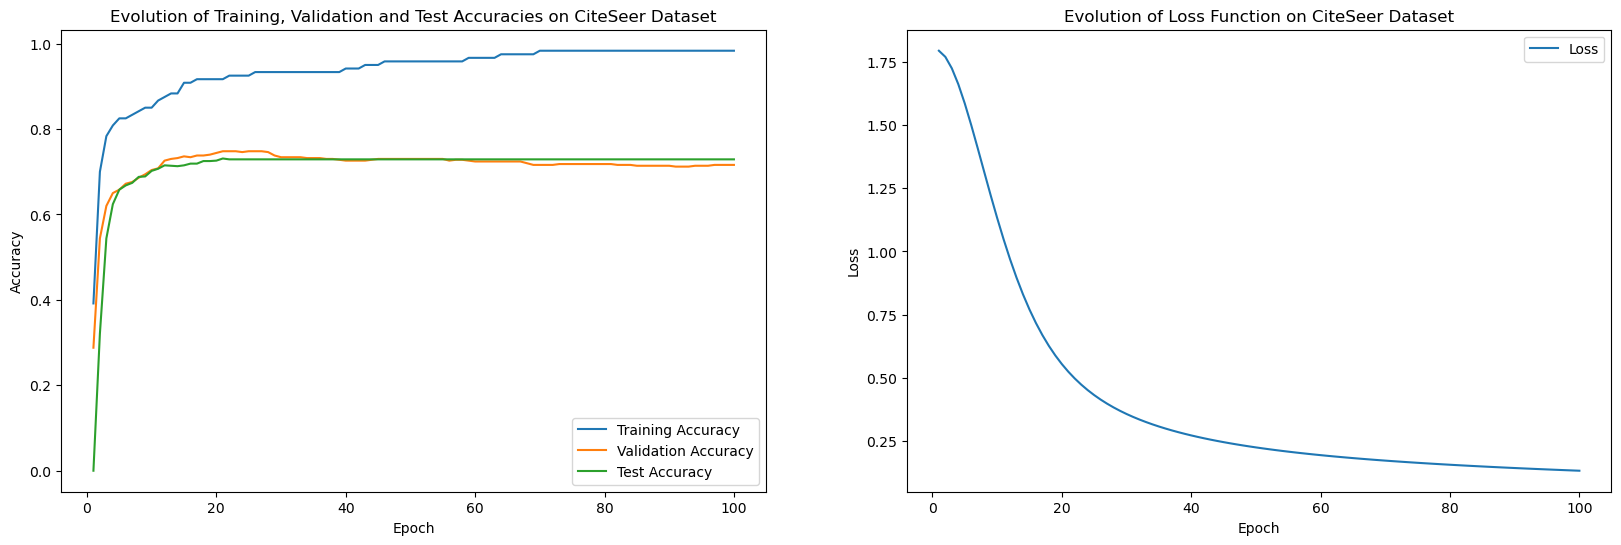

In [33]:
plotAccuraciesAndLoss()